In [1]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from Convenience import *

In [2]:
model = 'Rodrigues18/smd'
model_inter = 'Rodrigues18'

N_z, N_bins = 60, 100  ## number of redshift bins and bins in likelihood functions
zs = redshift_bins

In [13]:
with h5.File( likelihood_file_telescope) as f:
    print f['parkes/smd/primordial/Rodrigues18/Rodrigues18/smd/Piro18/wind/'].keys()

[u'DM']


compare with Kierdorf et al.

Text(0.5,1,'M51 observed S-band')

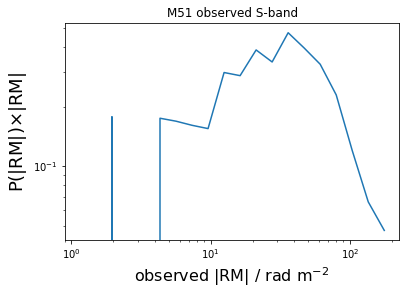

In [22]:
RM_M51 = np.genfromtxt('../../downloads/M51_RM_Sband.txt')
P, x = histogram( np.abs(RM_M51)[RM_M51 != 0.0], log=True, bins=20, density=True, range=[1,200] )
PlotLikelihood( x, P, measure='RM' )
plt.title( 'M51 observed S-band')



$\text{ Intervening Galaxies}$

combine raw likelihood functions of intervening galaxies in redshift bin to likelihood function of source. This is done by adding probabilities of different bins, weight by the probability to intersect galaxy in that bin.

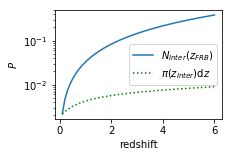

In [7]:
### plot likelihood for galaxies at redshift to intersect LoS, n_inter, which is used to weigh the redshift bins
### as well as expectet number of galaxies in LoS to source, N_inter

fig, ax = plt.subplots( figsize=(3,2) )

## values adopted from Marcquart & Koay 2013
n_gal = 0.02*hubble_constant**3   ### choose n(z) according to merger tree !!!
r_gal = 0.01/hubble_constant      ### choose r(z) ???


pi_inter = PriorInter( redshift_bins[-1], r=r_gal, n=n_gal )
n_inter = nInter( redshift_bins[-1], r=r_gal, n=n_gal )
N_inter = NInter( redshift_bins[-1], r=r_gal, n=n_gal )

plt.plot( redshift_bins, N_inter, label=r"$N_{Inter}(z_{FRB})$" )
plt.plot( redshift_bins, n_inter, linestyle=':', label=r"$\pi(z_{Inter})$d$z$", color='green' )
plt.xlabel('redshift')
plt.ylabel(r"$P$")
plt.yscale( 'log')
plt.legend()

weights = pi_inter
norms = np.cumsum(weights)
redshift_L = redshift_bins - np.diff(redshift_range)/2


read out raw data of Rodrigues et al. 2018

In [11]:
import pandas as pd
raw_data = pd.read_csv('../likelihood/Rodrigues18_RM_intervening.csv', sep=',',)

#raw_data = np.genfromtxt('../likelihood/Rodrigues18_RM_intervening.csv', delimiter=',', )

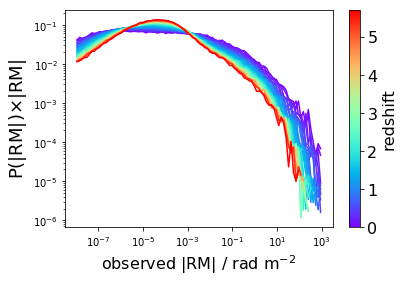

In [73]:

cols = raw_data.columns
redshifts_inter = np.round(cols[1:].astype('f'),2)
xx = 10.**raw_data[cols[0]]
x = 10.**np.linspace(-8,3,101)
dx = np.diff(x)
fig, ax = plt.subplots()
#fig, axs = plt.subplots(1,2, figsize=(8,3), sharey=True)
#ax=axs[0]
for col, color in zip( cols[1:], Rainbow(redshifts_inter) ):
    P = raw_data[col] #/dx
    pdf = P/dx
    PlotLikelihood( x, pdf, ax=ax, color=color, measure='RM' )
#    axs[1].loglog( xx, P, color=color )
#plt.xlabel( 'RM / %s' % units['RM'])
#plt.ylabel('P')
Colorbar( redshifts_inter, label='redshift')

In [43]:
x

0    -7.945
1    -7.835
2    -7.725
3    -7.615
4    -7.505
5    -7.395
6    -7.285
7    -7.175
8    -7.065
9    -6.955
10   -6.845
11   -6.735
12   -6.625
13   -6.515
14   -6.405
15   -6.295
16   -6.185
17   -6.075
18   -5.965
19   -5.855
20   -5.745
21   -5.635
22   -5.525
23   -5.415
24   -5.305
25   -5.195
26   -5.085
27   -4.975
28   -4.865
29   -4.755
      ...  
70   -0.245
71   -0.135
72   -0.025
73    0.085
74    0.195
75    0.305
76    0.415
77    0.525
78    0.635
79    0.745
80    0.855
81    0.965
82    1.075
83    1.185
84    1.295
85    1.405
86    1.515
87    1.625
88    1.735
89    1.845
90    1.955
91    2.065
92    2.175
93    2.285
94    2.395
95    2.505
96    2.615
97    2.725
98    2.835
99    2.945
Name: Unnamed: 0, Length: 100, dtype: float64

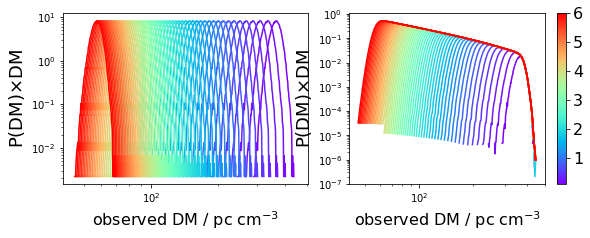

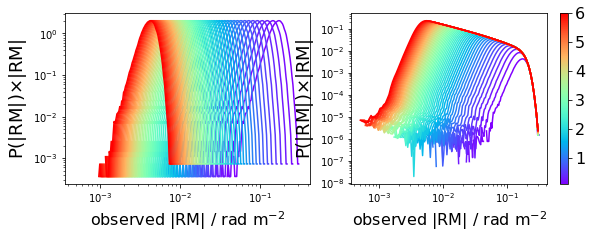

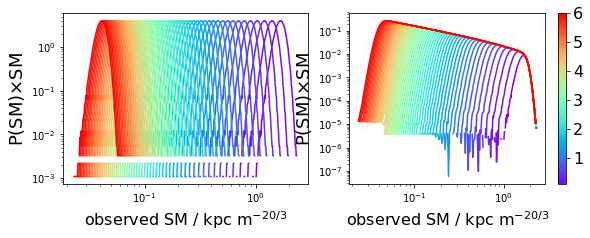

In [16]:
measures = [ 'DM', 'RM', 'SM' ]  ## scattering time needs special treatment in own notebook

fig, axs1 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs2 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs3 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
axs = [ axs1, axs2, axs3 ]

for measure, axs in zip( measures, axs ):
    for i_s, (z_s, color) in enumerate( zip( redshift_bins, rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
        Ps, xs = [], []
        for i_L , (z_L, color_L) in enumerate( zip( redshift_L[:i_s+1], rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
            ### read raw P(DM_Inter|z_L)a
            P, x = GetLikelihood_Inter( redshift=redshift_bins[i_L], model=model_inter+'/raw', measure=measure)
            if i_s == len(redshift_bins) - 1:
                PlotLikelihood( x, P, measure=measure, color=color_L, ax=axs[0] )
            Ps.append(P)
            xs.append(x)
        P, x = LikelihoodsAdd( Ps, xs, weights=weights[:i_s+1], renormalize=norms[i_s] )
        PlotLikelihood( x, P, measure=measure, color=color, ax=axs[1] )
        Write2h5( filename=likelihood_file_galaxy, datas=[P,x], 
                 keys=[ KeyInter( redshift=z_s, model=model_inter, measure=measure, axis=axis) for axis in ['P','x'] ] 
                )

plt.show()


create fake galaxy results for tests

1.0


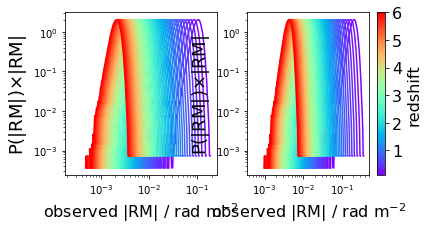

In [12]:
RM_0 = 0.1 # rad m^-2
sigma = 0.2 # log-scaled deviation

#RMs = np.random.lognormal(mean=RM_0, sigma=sigma, size=100000)
RMs = np.random.normal(loc=RM_0, scale=sigma/10, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = histogram( data=RMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='RM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='RM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**2
    x_ = x/(1+z)**2
    PlotLikelihood( x_, P_,  measure='RM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='RM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='RM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='RM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


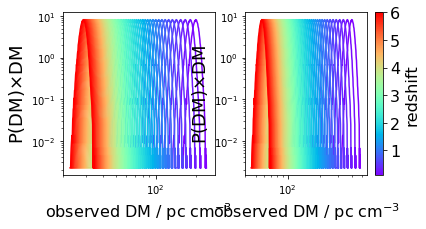

In [13]:
DM_0 = 200 # pc cm^-3
sigma = 10. # log-scaled deviation

DMs = np.random.normal(loc=DM_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = histogram( data=DMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='DM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='DM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)
    x_ = x/(1+z)
    PlotLikelihood( x_, P_,  measure='DM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='DM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='DM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='DM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


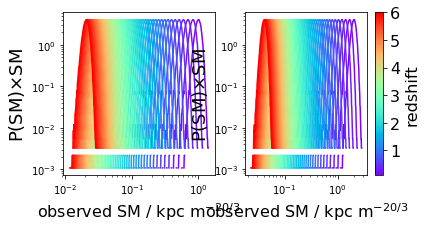

In [14]:
SM_0 = 1 # kpc m^-20/3
sigma = 0.1 # deviation

SMs = np.random.normal(loc=SM_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = histogram( data=SMs, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='SM', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='SM', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**2
    x_ = x/(1+z)**2
    PlotLikelihood( x_, P_,  measure='SM', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='SM', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='SM', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='SM', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


1.0


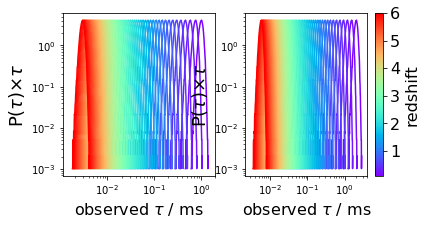

In [15]:
tau_0 = 1 #  ms
sigma = 0.1 # deviation

taus = np.random.normal(loc=tau_0, scale=sigma, size=100000)


colors = rainbow( np.linspace( 0, 1, len(zs)+1 ) )


fig, axs = plt.subplots( 1, 2, figsize=(6,3))

P, x = histogram( data=taus, bins=N_bins, density=True, log=True)
PlotLikelihood( x, P,  measure='tau', color=colors[0], ax=axs[0])
#'''
x_ = x*2  # rough estimate for intervening galaxies
P_ = P/ np.sum( P*np.diff(x_) )
print np.sum( P_*np.diff(x_) )
        
PlotLikelihood( x_, P_,  measure='tau', color=colors[0], ax=axs[1])
#'''
for z, color in zip( zs, colors[1:] ):
    P_ = P*(1+z)**3
    x_ = x/(1+z)**3
    PlotLikelihood( x_, P_,  measure='tau', color=color, ax=axs[0])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyHost( redshift=z, model='Rodrigues18/smd', measure='tau', axis=axis) for axis in ['P','x'] ] )
    x_ *= 2  # rough estimate for intervening galaxies
    P_ /= np.sum( P_*np.diff(x_) )
    if not np.round( np.sum( P_*np.diff(x_) ), 4) == 1.:
        print np.sum( P_*np.diff(x_) )
    PlotLikelihood( x_, P_,  measure='tau', color=color, ax=axs[1])
    Write2h5( likelihood_file_galaxy, [P_, x_], [KeyInter( redshift=z, model='Rodrigues18/raw', measure='tau', axis=axis) for axis in ['P','x'] ] )
    
#mp = plt.imsave( 'imsave.png', zs.reshape([len(zs),1]), cmap=rainbow )

Colorbar( zs, label='redshift' ) #, position=[0.5,0.15,0.05,0.7] )


This following is not needed, since all the info is already incoded in results of Rodrigues et al.

In [2]:
def Schechter( M, M_star=1, phi1=1, alpha1=1, phi2=1, alpha2=1):
    return ( phi1 * ( M / M_star )**alpha1 + phi2 * ( M / M_star )**alpha2 ) * np.exp( -M/M_star ) / M_star

In [3]:
## Best fit parameters from Davidzon et al. 2017, Tab. 1, redshifts are extended to z=0 and z=6
parameters = np.genfromtxt( 'COSMOS2015_Schechter_fit.txt', names=True)
parameters['M_star'] = 10.**parameters['M_star']

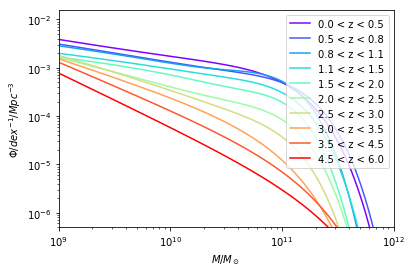

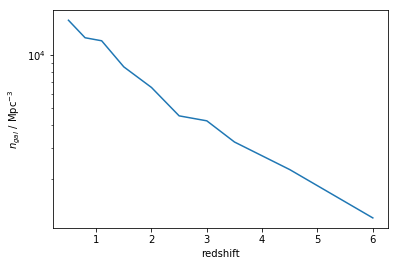

In [17]:
Ms = 10.**np.linspace(9,12,101)
dMs = np.diff(Ms)
n_gal = []
colors = rainbow( np.linspace( 0, 1, len(parameters) ) )
for p, c in zip( parameters, colors ):
    phi = Schechter( Ms, M_star=p['M_star']*1.067, phi1=p['phi1'], alpha1=p['alpha1'], phi2=p['phi2'], alpha2=p['alpha2']) 
    ### correct unit prefactors !!!
    n_gal.append( np.sum( phi[:-1]*dMs ) )
    plt.loglog( Ms[:-1]+dMs/2, phi[:-1]*dMs/110.2, label='%.1f < z < %.1f' % ( p['z0'], p['z1'] ), color=c )
plt.legend()
plt.xlabel('$M/M_\odot$')
plt.ylabel('$\Phi/dex^{-1}/Mpc^{-3}$')
plt.ylim(10.**-6.3, 10.**-1.8)
plt.xlim(1e9, 1e12)
plt.show()

plt.plot( parameters['z1'], n_gal )
plt.ylabel('$n_{gal}$ / Mpc$^{-3}$')
plt.xlabel('redshift')
plt.yscale('log')
plt.show()

In [13]:
len(parameters)


10

In [17]:
import yt
co = yt.utilities.cosmology.Cosmology()
radial_distance = co.comoving_radial_distance